<a href="https://colab.research.google.com/github/Alphaomegainfinity/yahoo_stocks_market/blob/main/yahoo_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# !pip install yfinance
# !pip install ipympl
# !pip list | grep pybigquery
# !pip install pybigquery
# !pip install --upgrade sqlalchemy
# !pip install --upgrade pandas
!pip install bigquery

In [4]:
# %matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()

# import dependencies
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import os
from tqdm import tqdm

# import sqlalchemy for database connection
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import inspect
from sqlalchemy.orm import sessionmaker

#Config should contain database username as username and database password as password
# from config import password

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [5]:
url = 'https://finance.yahoo.com/world-indices'
tables = pd.read_html(url)
world_stocks = tables[0]
world_stocks

,Symbol,Name,Last Price,Change,% Change,Volume,Intraday High/Low,52 Week Range,Day Chart
0,^GSPC,S&P 500,4434.80,29.09,+0.66%,NaN,NaN,NaN,NaN
1,^DJI,Dow 30,34591.64,244.74,+0.71%,NaN,NaN,NaN,NaN
2,^IXIC,Nasdaq,13718.25,127.60,+0.94%,NaN,NaN,NaN,NaN
3,^NYA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,^XAX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,^BUK100P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,^RUT,Russell 2000,1853.63,7.35,+0.40%,NaN,NaN,NaN,NaN
7,^VIX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,^FTSE,FTSE 100,7338.58,4.95,+0.07%,NaN,NaN,NaN,NaN
9,^GDAXI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def fetch_data(ticker_symbol):
    try:
        ticker = yf.Ticker(ticker_symbol)
        today = datetime.date.today().strftime('%Y-%m-%d')
        data = ticker.history(start="1900-01-01", end=today)
        data.reset_index(inplace=True)
        data['ticker'] = ticker_symbol
        return data
    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return None

In [7]:
all_data = []
for symbol in tqdm(world_stocks['Symbol'], desc="Fetching data"):  # tqdm progress bar!
    single_data = fetch_data(symbol)
    if single_data is not None:
        all_data.append(single_data)

# Concatenate all the individual datasets into one
master_data_origin = pd.concat(all_data, ignore_index=True)
master_data_origin

Fetching data: 100%|██████████| 36/36 [00:20<00:00,  1.76it/s]


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,Adj Close
0,1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0.0,0.0,0.0,^GSPC,NaN
1,1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0.0,0.0,0.0,^GSPC,NaN
2,1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0.0,0.0,0.0,^GSPC,NaN
3,1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0.0,0.0,0.0,^GSPC,NaN
4,1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0.0,0.0,0.0,^GSPC,NaN
...,...,...,...,...,...,...,...,...,...,...
284140,2023-08-21 00:00:00+02:00,3818.739990,3889.449951,3816.969971,3861.469971,0.0,0.0,0.0,^JN0U.JO,NaN
284141,2023-08-22 00:00:00+02:00,3891.000000,3950.280029,3873.770020,3883.989990,0.0,0.0,0.0,^JN0U.JO,NaN
284142,2023-08-23 00:00:00+02:00,3887.750000,3977.760010,3886.830078,3975.689941,0.0,0.0,0.0,^JN0U.JO,NaN
284143,2023-08-24 00:00:00+02:00,3969.169922,4003.260010,3929.610107,3947.600098,0.0,0.0,0.0,^JN0U.JO,NaN


In [8]:
# Checking any missing values per column and per rows
def data_checking(master_data_check):
    # Identify NaN or empty values
    missing_values = master_data_check.isna().sum()

    # Identify incorrect value types
    incorrect_types = master_data_check.apply(lambda x: pd.to_numeric(x, errors='coerce').isna().sum())

    # Combine the results into a DataFrame
    cleaning_report = pd.DataFrame({'Missing Values': missing_values, 'Incorrect Types': incorrect_types})

    return cleaning_report

In [9]:
data_checking(master_data_origin)

,Missing Values,Incorrect Types
Date,0,284145
Open,0,0
High,0,0
Low,0,0
Close,0,0
Volume,0,0
Dividends,0,0
Stock Splits,0,0
ticker,0,284145
Adj Close,284145,284145


In [10]:
# Copy the dataframe
master_data = master_data_origin.copy()

In [11]:
# Drop off the Adj Close column
master_data = master_data.drop(columns=['Adj Close'])

# Correct the Date column data type
master_data['Date'] = pd.to_datetime(master_data['Date'], utc = True)
master_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
0,1927-12-30 05:00:00+00:00,17.660000,17.660000,17.660000,17.660000,0.0,0.0,0.0,^GSPC
1,1928-01-03 05:00:00+00:00,17.760000,17.760000,17.760000,17.760000,0.0,0.0,0.0,^GSPC
2,1928-01-04 05:00:00+00:00,17.719999,17.719999,17.719999,17.719999,0.0,0.0,0.0,^GSPC
3,1928-01-05 05:00:00+00:00,17.549999,17.549999,17.549999,17.549999,0.0,0.0,0.0,^GSPC
4,1928-01-06 05:00:00+00:00,17.660000,17.660000,17.660000,17.660000,0.0,0.0,0.0,^GSPC


In [12]:
# rearrange the columns and remove the hour from the date
master_data = master_data[['ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
master_data['Date'] = pd.to_datetime((master_data['Date']).dt.date)

# remove '^' from the ticker
master_data['ticker'] = master_data['ticker'].str.replace('^', '').astype(str)
master_data

<ipython-input-12-f1ffa0fcbe6d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_data['Date'] = pd.to_datetime((master_data['Date']).dt.date)


,ticker,Date,Open,High,Low,Close,Volume
0,GSPC,1927-12-30,17.660000,17.660000,17.660000,17.660000,0.0
1,GSPC,1928-01-03,17.760000,17.760000,17.760000,17.760000,0.0
2,GSPC,1928-01-04,17.719999,17.719999,17.719999,17.719999,0.0
3,GSPC,1928-01-05,17.549999,17.549999,17.549999,17.549999,0.0
4,GSPC,1928-01-06,17.660000,17.660000,17.660000,17.660000,0.0
...,...,...,...,...,...,...,...
284140,JN0U.JO,2023-08-20,3818.739990,3889.449951,3816.969971,3861.469971,0.0
284141,JN0U.JO,2023-08-21,3891.000000,3950.280029,3873.770020,3883.989990,0.0
284142,JN0U.JO,2023-08-22,3887.750000,3977.760010,3886.830078,3975.689941,0.0
284143,JN0U.JO,2023-08-23,3969.169922,4003.260010,3929.610107,3947.600098,0.0


In [13]:
master_data.dtypes

ticker            object
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object

In [14]:
data_checking(master_data)

,Missing Values,Incorrect Types
ticker,0,284145
Date,0,0
Open,0,0
High,0,0
Low,0,0
Close,0,0
Volume,0,0


In [15]:
# Adding "Movement" column to calculate the difference movement during a trading day
# master_data ['Movement'] = master_data ['Close'] - master_data ['Open']

# master_data['Color'] = master_data['Movement'].apply(lambda x: 'green' if x >= 0 else 'red')

In [16]:
# create a list of unique stock symbols
stock_symbols = master_data['ticker'].unique().tolist()

# Split data into individual stocks
individual_stocks = {}
for ticker_name in master_data['ticker'].unique():
    individual_stocks[ticker_name] = master_data[master_data['ticker'] == ticker_name]
    individual_stocks[ticker_name].reset_index(inplace=True, drop=True)

individual_stocks['GSPC']

,ticker,Date,Open,High,Low,Close,Volume
0,GSPC,1927-12-30,17.660000,17.660000,17.660000,17.660000,0.000000e+00
1,GSPC,1928-01-03,17.760000,17.760000,17.760000,17.760000,0.000000e+00
2,GSPC,1928-01-04,17.719999,17.719999,17.719999,17.719999,0.000000e+00
3,GSPC,1928-01-05,17.549999,17.549999,17.549999,17.549999,0.000000e+00
4,GSPC,1928-01-06,17.660000,17.660000,17.660000,17.660000,0.000000e+00
...,...,...,...,...,...,...,...
24023,GSPC,2023-08-21,4380.279785,4407.549805,4360.299805,4399.770020,3.726850e+09
24024,GSPC,2023-08-22,4415.330078,4418.589844,4382.770020,4387.549805,3.522760e+09
24025,GSPC,2023-08-23,4396.439941,4443.180176,4396.439941,4436.009766,3.837270e+09
24026,GSPC,2023-08-24,4455.160156,4458.299805,4375.549805,4376.310059,3.723470e+09


In [17]:
print (stock_symbols)

['GSPC', 'DJI', 'IXIC', 'NYA', 'XAX', 'BUK100P', 'RUT', 'VIX', 'FTSE', 'GDAXI', 'FCHI', 'STOXX50E', 'N100', 'BFX', 'IMOEX.ME', 'N225', 'HSI', '000001.SS', '399001.SZ', 'STI', 'AXJO', 'AORD', 'BSESN', 'JKSE', 'KLSE', 'NZ50', 'KS11', 'TWII', 'GSPTSE', 'BVSP', 'MXX', 'IPSA', 'MERV', 'TA125.TA', 'JN0U.JO']


In [18]:
data = individual_stocks['JKSE'].copy()
data.set_index('Date', inplace=True)
data=data.asfreq('B') # 'B' is for business days
# Drop off all rows that have more than 5 missing values
data = data.dropna(thresh=len(data.columns)-5)

data

,ticker,Open,High,Low,Close,Volume
Date,,,,,,
1990-04-05,JKSE,641.268982,641.268982,641.268982,641.268982,0.0
1990-04-09,JKSE,632.085999,632.085999,632.085999,632.085999,0.0
1990-04-10,JKSE,634.692993,634.692993,634.692993,634.692993,0.0
1990-04-11,JKSE,639.614014,639.614014,639.614014,639.614014,0.0
1990-04-16,JKSE,641.872986,641.872986,641.872986,641.872986,0.0
...,...,...,...,...,...,...
2023-08-17,JKSE,6899.830078,6899.830078,6856.378906,6859.912109,130737900.0
2023-08-21,JKSE,6866.033203,6927.448242,6860.688965,6916.450195,158573900.0
2023-08-22,JKSE,6916.450195,6959.432129,6916.450195,6921.410156,170674700.0


In [19]:

features = ['Open', 'High', 'Low']
target = 'Close'

X = data[features]
y = data[target]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize models
arima_model = ARIMA(y_train, order=(5, 1, 0))
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)

# LSTM requires 3D input
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='RMSprop', loss='mse') # try different optimizer: adam, SGD or RMSprop
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train models
arima_model_fit = arima_model.fit()
rf_model.fit(X_train_scaled, y_train)
gb_model.fit(X_train_scaled, y_train)
lstm_model.fit(X_train_lstm, y_train, epochs=2000, batch_size=25, validation_data=(X_test_lstm, y_test), callbacks=[early_stopping])

# Predictions
arima_preds = arima_model_fit.forecast(steps=len(y_test))
rf_preds = rf_model.predict(X_test_scaled)
gb_preds = gb_model.predict(X_test_scaled)
lstm_preds = lstm_model.predict(X_test_lstm)
lstm_preds = lstm_preds.reshape(-1)

# Create a date-based index for forecasted results, indexing based on business days.
forecast_start_date = y_test.index[0]
forecast_periods = len(arima_preds)
forecast_index = pd.bdate_range(start=forecast_start_date, periods=forecast_periods, freq='C', weekmask='1001000')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

Epoch 1/2000
183/183 [==============================] - 5s 10ms/step - loss: 12303984.0000 - val_loss: 12033770.0000
Epoch 2/2000
183/183 [==============================] - 1s 3ms/step - loss: 12272466.0000 - val_loss: 11998201.0000
Epoch 3/2000
183/183 [==============================] - 1s 3ms/step - loss: 12235362.0000 - val_loss: 11961499.0000
Epoch 4/2000
183/183 [==============================] - 1s 4ms/step - loss: 12198052.0000 - val_loss: 11925736.0000
Epoch 5/2000
183/183 [==============================] - 1s 3ms/step - loss: 12162411.0000 - val_loss: 11891160.0000
Epoch 6/2000
183/183 [==============================] - 1s 3ms/step - loss: 12127463.0000 - val_loss: 11857328.0000
Epoch 7/2000
183/183 [==============================] - 1s 3ms/step - loss: 12093695.0000 - val_loss: 11824776.0000
Epoch 8/2000
183/183 [==============================] - 1s 3ms/step - loss: 12060589.0000 - val_loss: 11792118.0000
Epoch 9/2000
183/183 [==============================] - 1s 3ms/step - l

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


62/62 [==============================] - 1s 2ms/step


In [20]:
# Evaluate models
print("ARIMA")
print("MSE:", mean_squared_error(y_test, arima_preds))
print("MAE:", mean_absolute_error(y_test, arima_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, arima_preds)))

print("\nRandom Forest")
print("MSE:", mean_squared_error(y_test, rf_preds))
print("MAE:", mean_absolute_error(y_test, rf_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))

print("\nGradient Boosting")
print("MSE:", mean_squared_error(y_test, gb_preds))
print("MAE:", mean_absolute_error(y_test, gb_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, gb_preds)))

print("\nLSTM")
print("MSE:", mean_squared_error(y_test, lstm_preds))
print("MAE:", mean_absolute_error(y_test, lstm_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, lstm_preds)))

# Print the forecasted results with proper date index
forecast_df = pd.DataFrame({'ARIMA': arima_preds, 'RF': rf_preds, 'GB': gb_preds, 'LSTM': lstm_preds}, index=forecast_index)
print(forecast_df)

ARIMA
MSE: 6463200.032226187
MAE: 2354.7950105475165
RMSE: 2542.282445407313

Random Forest
MSE: 300.8902129429616
MAE: 9.507053190733775
RMSE: 17.34618727395048

Gradient Boosting
MSE: 475.9760977621287
MAE: 13.719633712444963
RMSE: 21.816876443756303

LSTM
MSE: 384.17079795727676
MAE: 11.094943588530011
RMSE: 19.60027545615818
            ARIMA           RF           GB         LSTM
2020-08-20    NaN  5305.186396  5290.953097  5293.297363
2020-08-24    NaN   577.319122   558.156885   565.379333
2020-08-27    NaN   470.807445   470.865050   470.802673
2020-08-31    NaN  6228.193389  6220.986219  6221.301270
2020-09-03    NaN  6356.777959  6312.763145  6339.858887
...           ...          ...          ...          ...
2039-04-28    NaN  5156.918350  5160.482479  5168.583496
2039-05-02    NaN  4008.693535  4033.794389  4016.739502
2039-05-05    NaN  5811.661860  5809.265565  5807.990723
2039-05-09    NaN   419.015171   420.922012   423.334778
2039-05-12    NaN   588.842198   597.93491

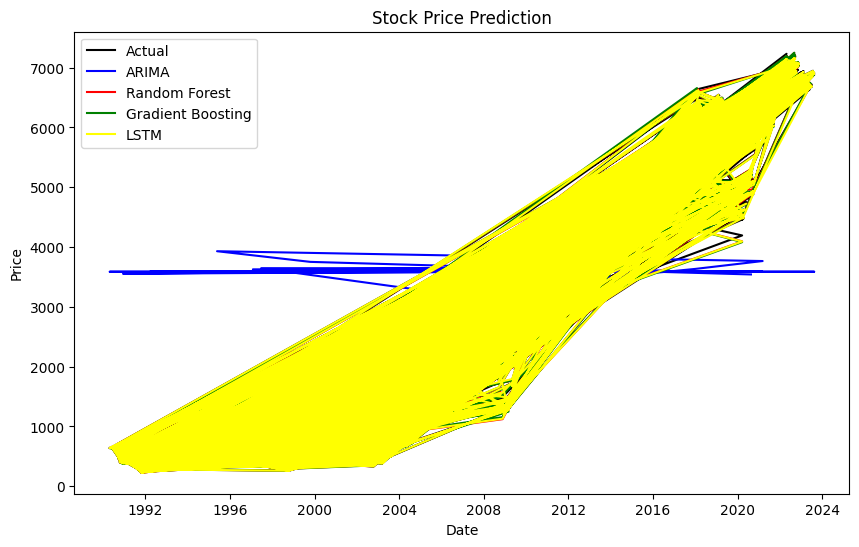

In [21]:
# Plot actual vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual', color='black')
plt.plot(y_test.index, arima_preds, label='ARIMA', color='blue')
plt.plot(y_test.index, rf_preds, label='Random Forest', color='red')
plt.plot(y_test.index, gb_preds, label='Gradient Boosting', color='green')
plt.plot(y_test.index, lstm_preds, label='LSTM', color='yellow')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.show()

In [22]:
# save all the model for future use:
import joblib

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#save as h5 type
arima_model_fit.save('/content/drive/My Drive/arisma_model.h5')
joblib.dump(rf_model,'/content/drive/My Drive/rf_model.h5')
joblib.dump(gb_model,'/content/drive/My Drive/gb_model.h5')
lstm_model.save('/content/drive/My Drive/lstm_model.h5')

# Save the entire model as a `.keras` zip archive.
arima_model_fit.save('/content/drive/My Drive/arisma.keras')
joblib.dump(rf_model,'/content/drive/My Drive/rf.keras')
joblib.dump(gb_model,'/content/drive/My Drive/gb.keras')
lstm_model.save('/content/drive/My Drive/lstm.keras')

Mounted at /content/drive


In [24]:
import google.cloud.bigquery as bigquery

# client = bigquery.Client()

# dataset_ref = client.dataset('bq-dataset')
# table_ref = dataset_ref.table('bq-table')

# engine = sqlalchemy.create_engine('bigquery://')

# schema = Table('stocks', engine,
#               Column('ticker', String, primary_key=True),
#               Column('Date', DateTime, primary_key=True),
#               Column('Open', Float),
#               Column('High', Float),
#               Column('Low', Float),
#               Column('Close', Float),
#               Column('Volume', Float))

# schema.create()

# job_config = bigquery.LoadJobConfig()
# job_config.schema = master_data.schema

# load_job = client.load_table_from_dataframe(master_data, table_ref, job_config=job_config)

# load_job.result()

import sqlalchemy
from sqlalchemy import create_engine, Column, String, DateTime, Float
from sqlalchemy.ext.declarative import declarative_base

Base = declarative_base()

# Define your table class
class Stocks(Base):
    __tablename__ = 'stocks'
    ticker = Column(String, primary_key=True)
    Date = Column(DateTime, primary_key=True)
    Open = Column(Float)
    High = Column(Float)
    Low = Column(Float)
    Close = Column(Float)
    Volume = Column(Float)

# Create the engine
engine = create_engine('bigquery://norse-botany-384314')

# Create the table schema
Base.metadata.create_all(engine)

<ipython-input-24-494681c33c28>:32: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()
<ipython-input-24-494681c33c28>:46: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'pybigquery.sqlalchemy_bigquery.BigQueryDialect'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  engine = create_engine('bigquery://norse-botany-384314')


RefreshError: ignored